In [1]:
import torch
import numpy as np
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import matlib
import pandas as pd

from dictionary import *
from utils import *
from main import *
from benchmark_models import *
from compartment_models import *


In [2]:
np.random.seed(3)

In [3]:
#Parameters
d = 4 # Dimension of the state space

# Tfinal and timesteps
Tfinal = 180.0
dt_fine = 0.01
timesteps_fine = int(Tfinal/dt_fine)

days = 100
dt = 1.0
timesteps = int(Tfinal/dt)
train_ratio_vec = [0.3,0.54,0.7]

In [4]:
'''Description: Solve the ODE to build the input data'''

# Reference: https://cs.uwaterloo.ca/~paforsyt/SEIR.html
x0 = np.zeros(4)
x0[2] = 1 #I
x0[1] = 0 #E 
x0[0] = 10**6  #S
x0[3] = 0  #R

P = np.sum(x0)  # N = total population

y0_mu = x0/P

sigma_true = 1/4 
gamma_true = 1/14 
beta_true = 3/14 
mu_true = 0.75
tspan_fine = np.linspace(0,Tfinal,timesteps_fine+1) #Tfinal = 180


solMu_clean_fine = odeint(seirMu_function, y0_mu, tspan_fine, args=(beta_true,sigma_true,gamma_true,mu_true), tfirst = True)# sol is (timesteps by d)
solMu_clean = solMu_clean_fine[0:-1:days,:]

print('the size of solution is',solMu_clean.shape)

the size of solution is (180, 4)


In [5]:
'''Description: Create output data'''
obs_var = 2

#add noise
eta = 0.05
noiseType = '1'
I_noisy = noisy_data(solMu_clean[:,2],eta,timesteps,noiseType) #dimension is (timesteps,)

#take 7-day avg
window = 7
I_data =rolling_avg(I_noisy,window)
I = I_data


#smooth the derivative: Method 1 (convolution filter)
dIdt = time_derivative(I.reshape(-1,1),dt,type = 2)
noise_smooth = eta
smooth_type = 'conv'
smooth_par = 15
dIdt_smooth = smooth(dIdt.squeeze(), smooth_par, noise_smooth)




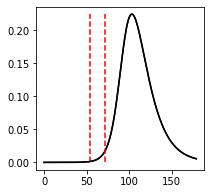

In [6]:
z = np.linspace(np.min(solMu_clean[:,2]),np.max(solMu_clean[:,2]),timesteps)
fig1 = plt.figure(figsize=(3,3))
for i in np.arange(0,len(train_ratio_vec)):
    y = int(train_ratio_vec[i]*Tfinal)*np.ones(timesteps)
    plt.plot(solMu_clean[:,2],'k')
    plt.plot(y,z,'r--')
# plt.legend()

In [7]:
out_mat = spade4(I_data,dIdt_smooth,train_ratio_vec,d,timesteps)

[0.3, 0.4]
0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.630853046804453e-07, tolerance: 9.461219356163277e-11
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.451214700252924e-10, tolerance: 9.461219356163277e-11
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.05229485928846e-06, tolerance: 9.461219356163277e-11
  positive)


1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.466218637935662e-07, tolerance: 3.4281570341749994e-10
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.562025725084123e-09, tolerance: 3.4281570341749994e-10
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.78074257980772e-07, tolerance: 3.4281570341749994e-10
  positive)


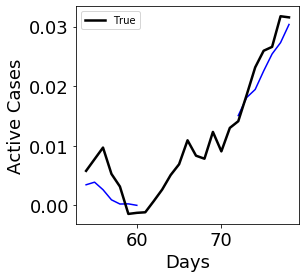

In [8]:
thickness = 2.5
val_window = 7
plt.figure(figsize=(4,4))
for i in np.arange(0,len(train_ratio_vec)):
    plt.plot(range(int(train_ratio_vec[i]*(timesteps)),
                   int(train_ratio_vec[i]*(timesteps))+val_window),out_mat[:,i],'b') #,label = 'Ours',linewidth=thickness)

plt.plot(range(int(train_ratio_vec[0]*(timesteps)),int(train_ratio_vec[-1]*(timesteps))+val_window),
         I[int(train_ratio_vec[0]*(timesteps)):int(train_ratio_vec[-1]*(timesteps))+val_window]
         ,'k',label = 'True',linewidth=thickness)
plt.legend()
plt.tick_params(labelsize = 18)
plt.xlabel('Days',fontsize=18)
plt.ylabel('Active Cases',fontsize=18)
plt.show()